# Numpyro Integration


> This notebook gives a demonstration of how one can use some of the numpyro integration features to enable one to offload some of the inference schemes. This will allow the user to focus more on GP model construction instead of GP model inference. Below we show some of the most important functions and features available within GPJax that will allow users to easily transform their models from standard GPJax to numpyro-like.`


In [3]:
%load_ext lab_black

import gpjax
import numpyro
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

key = jr.PRNGKey(123)
print(gpjax.__version__)
from pprint import pprint

%matplotlib inline
%load_ext autoreload
%autoreload 2

0.3.4


## Synthetic datasets

With the necessary libraries and modules imported we can simulate some data. We'll sample our inputs $x$ according to $x_1, \ldots , x_{50} \sim \mathcal{U}(-3., 3)$ and corresponding outputs will be,

$$y_i = \sin(4x_i) + \cos(2 x_i) + \epsilon_i,$$
    
such that $\epsilon_i \sim \mathcal{N}(0, 0.2)$.

In [4]:
N = 50
noise = 0.2

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

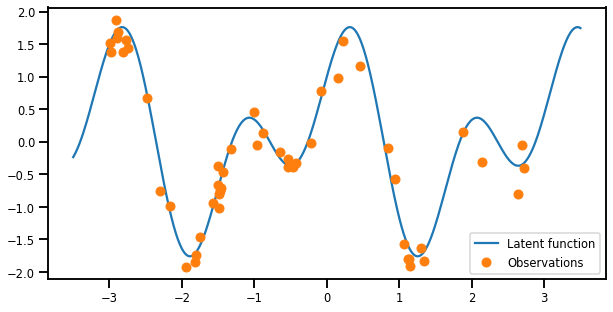

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.plot(x, y, "o", label="Observations", color="tab:orange")
ax.legend(loc="best")
plt.show()

## Gaussian Process Regression Model

Now in the original regression notebook, we showed how one can define a Gaussian process in GPJax. We need the following:

* A Prior
    * mean function
    * kernel function
* A Likelihood


Then, using the `*` operator, we get a GP posterior.

In [6]:
from gpjax.gps import Prior
from gpjax.mean_functions import Zero
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian

# GP Prior
mean_function = Zero()
kernel = RBF()
prior = Prior(mean_function=mean_function, kernel=kernel)

# GP Likelihood
lik = Gaussian()

# GP Posterior
posterior = prior * lik

### Parameters

The previous notebook also spent a good portion showing how one can initialize and constrain the parameters using the `GPJax` library. So below we will use the `initialise` function which will return a dictionary of the appropriate parameters.

In [7]:
from gpjax.parameters import initialise

params = initialise(posterior)

pprint(params)

{'lengthscale': DeviceArray([1.], dtype=float64),
 'obs_noise': DeviceArray([1.], dtype=float64),
 'variance': DeviceArray([1.], dtype=float64)}


However, numpyro models make use of numpyro primitives such as `param` and `sample`. So we need to translate the dictionary from the `GPJax` library to a dictionary that will be ready by the numpyro model.

Here is an example where we can take any dictionary with the key value as the parameter name and the item as either a `float` or a `jnp.DeviceArray`.

In [8]:
from gpjax.interfaces.numpyro import numpyro_dict_params

In [9]:
numpyro_params = numpyro_dict_params(params)
pprint(numpyro_params)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fb3ea2fe880>,
                 'init_value': DeviceArray([1.], dtype=float64),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fb3ea2fe880>,
               'init_value': DeviceArray([1.], dtype=float64),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fb3ea2fe880>,
              'init_value': DeviceArray([1.], dtype=float64),
              'param_type': 'param'}}


The result is a nested dictionary with the appropriate parameters to be read into the numpyro model. Notice how we have some default constraints already defined. This is because numpyro has it's own `Constraint` class. The default in this case is the `constraint.positive`. 

#### Modifying Constraints

We can also modify the parameters to other numpyro constraints via the `add_constraints` function. In the backend of `GPJax`, we have used multiple dispatch to allow different flavours of adding contraints. We show a few examples below:

**Example I** - We can add the same constraint everywhere.

In [10]:
from gpjax.interfaces.numpyro import add_constraints
from numpyro.distributions import constraints

# example 1 - adding positive for everything
numpyro_params_ = add_constraints(numpyro_params, constraints.softplus_positive)
pprint(numpyro_params_)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._SoftplusPositive object at 0x7fb3ea2fea90>,
                 'init_value': array([1.]),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._SoftplusPositive object at 0x7fb3ea2fea90>,
               'init_value': array([1.]),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._SoftplusPositive object at 0x7fb3ea2fea90>,
              'init_value': array([1.]),
              'param_type': 'param'}}



**Example II** - We can add a constraint to a specific variable.

In [11]:
# example 1 - adding positive for everything
numpyro_params_ = add_constraints(numpyro_params, "lengthscale", constraints.positive)
numpyro_params_

{'lengthscale': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7fb3ea2fe880>},
 'obs_noise': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7fb3f2bdf2b0>},
 'variance': {'param_type': 'param',
  'init_value': array([1.]),
  'constraint': <numpyro.distributions.constraints._GreaterThan at 0x7fb3f2bdf2b0>}}

**Example III** - We can add a dictionary of the constraints we want to add where the key defines the variable.

In [12]:
# example 1 - adding positive for everything
new_constraints = {
    "lengthscale": constraints.greater_than(0.01),
    "obs_noise": constraints.interval(0.1, 0.001),
}

numpyro_params_ = add_constraints(numpyro_params, new_constraints)
# pprint(numpyro_params)
pprint(numpyro_params_)

{'lengthscale': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fb3f2be4a00>,
                 'init_value': array([1.]),
                 'param_type': 'param'},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._Interval object at 0x7fb3f2be4a60>,
               'init_value': array([1.]),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fb3f2be4bb0>,
              'init_value': array([1.]),
              'param_type': 'param'}}


Please take a look at the numpyro docs for more [constraints](http://num.pyro.ai/en/stable/distributions.html#constraints). Some other useful ones include the `softplus_positive`, `softplus_lower_cholesky`, and `unit_interval`.

## Numpyro Model

So once we have defined our parameters and constraints, we're ready to jump into the modeling! We have a specialized function called the `numpyro_marginal_ll`. This will take a gp posterior and a dictionary of `numpyro_params` that we have previously defined. 

In [13]:
from gpjax.interfaces.numpyro import numpyro_marginal_ll
from gpjax.types import Dataset

training_ds = Dataset(X=x, y=y)

# initialize parameters
params = initialise(posterior)

# convert to numpyro-style params
numpyro_params = numpyro_dict_params(params)

# initialize numpyro-style GP model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

The result is a callable function which takes in a `GPJax` `Dataset` (a datalcass consisting of an `X` and `y`). Below is an example of how we can input this dataset with our newly defined model as well as get the set of parameters defined within the function.

In [14]:
with numpyro.handlers.seed(rng_seed=123):
    t_ = npy_model(training_ds)
    print(t_.shape)
    assert t_.shape[0] == x.shape[0]
    t = numpyro.handlers.trace(npy_model).get_trace(training_ds)
    print("Parameters:", list(t.keys()))

(50,)
Parameters: ['lengthscale', 'obs_noise', 'variance', 'y']


So the output size is the same as the input size and the parameters we obtain are the same (almost) as the input parameters.

### Approximate Inference with Guides

This is a very critical part of the numpyro and pyro framework. They use `guides` which work as approximate posteriors. They are fully parameterized and take in no observations. The simplest way to define a guide is to use the `autoguide` methods like the `AutoDelta`, `AutoLaplaceApproximation` and the `AutoNormal`. For more information, please see this excellent set of [tutorials](https://pyro.ai/examples/) provided by the num/pyro team.

In this example, we're going to use an `empty guide`. This works as a placeholder for now. By having an empty guide, we are effectively doing maximum likliehood (no priors). See [this tutorial](https://pyro.ai/examples/mle_map.html) for more information.

In [15]:
# approximate posterior
guide = lambda ds: None

### Optimization

So now that the model is defined (very simply), we are now ready to do optimization! These are the standard optimization procedures from numpyro.

In [16]:
%%time
from numpyro.infer import SVI, Trace_ELBO

# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 2_500


# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)

# stochastic variational inference (pseudo)
svi = SVI(npy_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), n_iterations, training_ds)

100%|██████████| 2500/2500 [00:05<00:00, 467.24it/s, init loss: 3273.3523, avg. loss [2376-2500]: 866.9415]


CPU times: user 16.5 s, sys: 1min 47s, total: 2min 3s
Wall time: 6.11 s


#### Losses

We can plot the losses by extracting them from the `svi_result`.

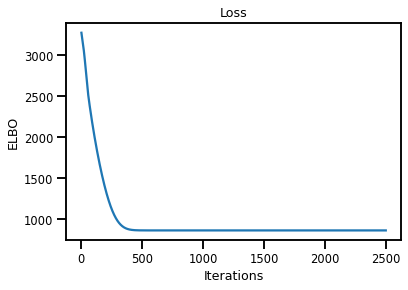

In [17]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="ELBO")
plt.show()

### Extracting the Parameters

Oncew we;ve trained the model, we can now extract the learned the parameters. Because we were doing MLE, we don't need to worry about any unconventional naming schemes (see below) thus we can simply call them directly.

In [18]:
# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'lengthscale': DeviceArray([0.4268455], dtype=float64),
 'obs_noise': DeviceArray([0.03674606], dtype=float64),
 'variance': DeviceArray([1.23430812], dtype=float64)}


And we see the parameters are ready to be used for predictions.

### Predictions

The rest of this section is **exactly** the same as the other tutorials. The resulting parameters have the same name, shape, type, etc. So you should not have to change your code from here.

In [19]:
from gpjax import mean, variance

meanf = mean(posterior, learned_params, training_ds)
varf = variance(posterior, learned_params, training_ds)


mu = meanf(xtest).squeeze()
cov = varf(xtest).squeeze()

one_stddev = 1.96 * jnp.sqrt(jnp.diag(cov))

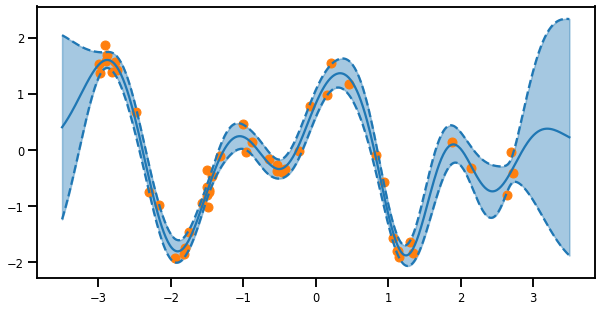

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

### Prior Parameters

Above, we showed how to do optimization on fixed priors with constraints. For this section, we want to highlight how one can attach priors to their hyperparameters.

In [21]:
import numpyro.distributions as dist

hyperpriors = {
    "lengthscale": dist.Gamma(1.0, 1.0),
    "variance": dist.HalfCauchy(scale=1.0),
    "obs_noise": dist.HalfCauchy(scale=5.0),
}

For the most part, there is no difference between how one can add priors to the dictionary.

**Example I** - Add a Prior to a specific variable

In [22]:
from gpjax.interfaces.numpyro import add_priors

numpyro_params = numpyro_dict_params(params)
numpyro_params_ = add_priors(numpyro_params, "lengthscale", dist.Gamma(1.0, 1.0))
pprint(numpyro_params_)

{'lengthscale': {'param_type': 'prior',
                 'prior': <numpyro.distributions.continuous.Gamma object at 0x7fb3e43037f0>},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fb3e4303790>,
               'init_value': array([1.]),
               'param_type': 'param'},
 'variance': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fb3e4303790>,
              'init_value': array([1.]),
              'param_type': 'param'}}


**Example II** - Adding a dictionary of priors.

In [23]:
from gpjax.interfaces.numpyro import add_priors

numpyro_params = numpyro_dict_params(params)
numpyro_params = add_priors(numpyro_params, hyperpriors)
pprint(numpyro_params)

{'lengthscale': {'param_type': 'prior',
                 'prior': <numpyro.distributions.continuous.Gamma object at 0x7fb3e435fb20>},
 'obs_noise': {'param_type': 'prior',
               'prior': <numpyro.distributions.continuous.HalfCauchy object at 0x7fb3e435fbe0>},
 'variance': {'param_type': 'prior',
              'prior': <numpyro.distributions.continuous.HalfCauchy object at 0x7fb3e435fac0>}}


#### Mixing Priors and Parameters

And yes, one can have a mixture of priors and parameters.

In [24]:
mixed_param_priors = {
    "lengthscale": dist.Gamma(1.0, 1.0),
    "variance": dist.HalfCauchy(scale=1.0),
    "obs_noise": 1.0,
}

numpyro_params = numpyro_dict_params(mixed_param_priors)
pprint(numpyro_params)

{'lengthscale': {'param_type': 'prior',
                 'prior': <numpyro.distributions.continuous.Gamma object at 0x7fb3e4295310>},
 'obs_noise': {'constraint': <numpyro.distributions.constraints._GreaterThan object at 0x7fb3ea2fe880>,
               'init_value': 1.0,
               'param_type': 'param'},
 'variance': {'param_type': 'prior',
              'prior': <numpyro.distributions.continuous.HalfCauchy object at 0x7fb3e42955b0>}}


**Warning**: Be careful with assigning constraints to priors. This will be ignored as numpyro has no method to add constraints on prior distributions. One would have to use another prior distribution which allows for constraints.

#### TensorFlow Probability

It's also worth mentioning that the numpyro devs were able to have some synergy between the [TFP](https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX) package and the numpyro package via their simple [wrapper](http://num.pyro.ai/en/stable/distributions.html#tensorflow-distributions). You just need to import it:

```python 
from numpyro.contrib.tfp import distributions as tfd
```

So this means that if there is a probability distribution that you TFP has that numpyro does not have, then most likely you can call that one.

### Maximum A Posteriori

So now that we have prior parameters, we need to use the guides in order to use stochastic variation inference (SVI). We saw above that an empty guide was used for MLE. But we'll find that the SVI method doesn't work if there is no approximate posterior to optimize over. So the simplest guide to use would be the `AutoDelta` which is equivalent to the MAP solution.

In [25]:
from numpyro.infer.autoguide import AutoDelta

# define hyperparameter priors
hyperpriors = {
    "lengthscale": dist.Gamma(1.0, 1.0),
    "variance": dist.HalfCauchy(scale=1.0),
    "obs_noise": dist.HalfCauchy(scale=5.0),
}

# create numpyro dictionary
numpyro_params = numpyro_dict_params(hyperpriors)

# initialize model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

# Delta Guide
guide = AutoDelta(npy_model)

### Optimization

In [26]:
%%time
from numpyro.infer import SVI, Trace_ELBO


# reproducibility
rng_key = jax.random.PRNGKey(0)
n_iterations = 1_000

# numpyro specific optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)

# stochastic variational inference (pseudo)
svi = SVI(npy_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(rng_key, n_iterations, training_ds)

100%|██████████| 1000/1000 [00:03<00:00, 316.36it/s, init loss: 5261.7675, avg. loss [951-1000]: 870.8055]


CPU times: user 11.8 s, sys: 57.7 s, total: 1min 9s
Wall time: 6.48 s


### Losses

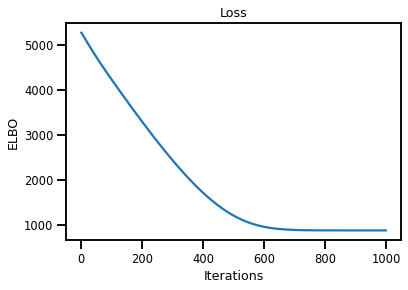

In [27]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="ELBO")
plt.show()

### Extracting the Parameters

Like the previous example, we can simple find the learned parameters.

In [28]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
pprint(learned_params)

{'lengthscale_auto_loc': DeviceArray(0.42626461, dtype=float64),
 'obs_noise_auto_loc': DeviceArray(0.03680386, dtype=float64),
 'variance_auto_loc': DeviceArray(1.22624705, dtype=float64)}


But you'll notice that there are some extra names attached. This is because these are parameters of the *approximate posterior*, namely the `loc` for the Delta distribution. A simple fix (in general) is to extract the median/mean parameters which will eliminate the extra tags on the name.

In [29]:
# Take them directly
median_params = guide.median(learned_params)
pprint(median_params)

{'lengthscale': DeviceArray(0.42626461, dtype=float64),
 'obs_noise': DeviceArray(0.03680386, dtype=float64),
 'variance': DeviceArray(1.22624705, dtype=float64)}


### Predictions

Again, the rest of the code is **exactly the same**.

In [30]:
from gpjax import mean, variance

meanf = mean(posterior, median_params, training_ds)
varf = variance(posterior, median_params, training_ds)


mu = meanf(xtest).squeeze()
cov = varf(xtest).squeeze()

one_stddev = 1.96 * jnp.sqrt(jnp.diag(cov))

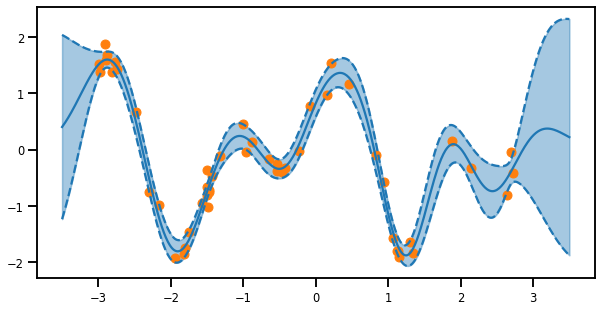

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

## Hamiltonian Monte Carlo

The last method for inference that we're going to look at is Monte Carlo. This is actually **la crème de la crème** for numpyro. They have a *blazing fast* HMC/NUTS inference scheme. In fact, JAX has been frequently praised for the speed of the MC schemes due to the `vmap` and `jit` primitives.

See this [paper](https://arxiv.org/abs/1912.11554) or this [blog post](https://luiarthur.github.io/TuringBnpBenchmarks/) for more details.

Below, we have an example of how one can use MCMC to do sampling. The model is exactly the same as the previous example except we do not need to define any guide functions.

In [32]:
hyperpriors = {
    "lengthscale": dist.Gamma(1.0, 1.0),
    "variance": dist.HalfCauchy(scale=1.0),
    "obs_noise": dist.HalfCauchy(scale=5.0),
}

numpyro_params = numpyro_dict_params(hyperpriors)

# initialize model
npy_model = numpyro_marginal_ll(posterior, numpyro_params)

In [33]:
from numpyro.infer import MCMC, NUTS


# reproducibility
rng_key = jax.random.PRNGKey(0)

# NUTS Parameters
n_samples = 1_000
n_warmup = 100
# Setup
kernel = NUTS(npy_model)

nuts_sampling = MCMC(kernel, num_samples=n_samples, num_warmup=n_warmup)
nuts_sampling.run(rng_key, training_ds)

sample: 100%|██████████| 1100/1100 [00:10<00:00, 102.02it/s, 7 steps of size 4.74e-01. acc. prob=0.96] 


It's quite fast... This notebook was run on a CPU of 16 cores. We can also check the convergence with the convenient `print_summary()` method.

In [34]:
nuts_sampling.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.43      0.01      0.43      0.41      0.44    669.52      1.00
    obs_noise      0.04      0.00      0.04      0.03      0.04    668.17      1.00
     variance      1.24      0.09      1.23      1.09      1.38    656.19      1.00

Number of divergences: 0


### Posterior Samples

We don't have any learned parameters so we have to extract the parameters manually. Below is an example along with a simple plot.

In [35]:
posterior_params_samples = nuts_sampling.get_samples()

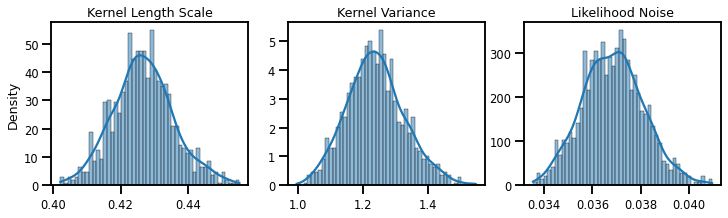

In [36]:
# Plot posteriors for the parameers
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(
    ax=ax[0],
    x=posterior_params_samples["lengthscale"],
    kde=True,
    bins=50,
    stat="density",
)
sns.histplot(
    ax=ax[1], x=posterior_params_samples["variance"], kde=True, bins=50, stat="density"
)
sns.histplot(
    ax=ax[2], x=posterior_params_samples["obs_noise"], kde=True, bins=50, stat="density"
)

ax[0].set(title="Kernel Length Scale")
ax[1].set(title="Kernel Variance", ylabel="")
ax[2].set(title="Likelihood Noise", ylabel="")

plt.show()

### Median Parameters

We could also do the same `median` trick as below. Again, these are samples so they don't augment the names.

In [37]:
def get_median_parameters(samples: dict) -> dict:
    median_params = {}
    for ikey, iarray in samples.items():
        median_params[ikey] = jnp.median(iarray)
    return median_params

In [38]:
median_params = get_median_parameters(posterior_params_samples)
pprint(median_params)

{'lengthscale': DeviceArray(0.42653491, dtype=float64),
 'obs_noise': DeviceArray(0.03683508, dtype=float64),
 'variance': DeviceArray(1.23494351, dtype=float64)}


### Predictions

We're repeating ourselves, but the predictions are **exactly the same** as all of the above examples.

In [39]:
from gpjax import mean, variance

meanf = mean(posterior, median_params, training_ds)
varf = variance(posterior, median_params, training_ds)


mu = meanf(xtest).squeeze()
cov = varf(xtest).squeeze()

one_stddev = 1.96 * jnp.sqrt(jnp.diag(cov))

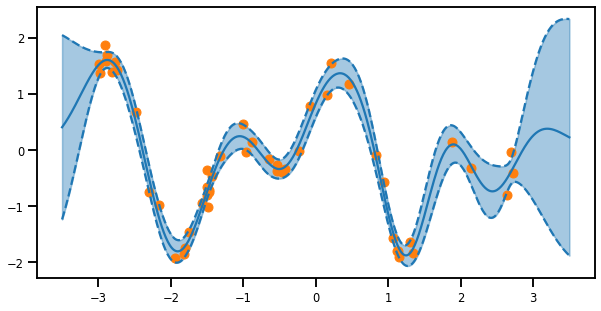

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu, color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
ax.plot(xtest, mu.ravel() - one_stddev, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev, linestyle="--", color="tab:blue")
plt.show()

### All Posteriors

Now, getting the median parameters is not really true Bayesian (although for this simple example, it's perfectly fine). Using some of the code from the previous notebook, we show how we can create random variables that we can sample from given each of the hyperparameters. 

In [41]:
from gpjax import random_variable


def sample_posterior_from_params(rng, params, posterior, xtest, ds, n_samples=1):
    # create a random variable given parameters
    predictive_rv = random_variable(posterior, params, ds)(xtest)
    # sample from the rv
    return predictive_rv.sample(sample_shape=(n_samples,), seed=rng).squeeze()


# JIT make the sampling faster
sample_posterior = jax.jit(
    jax.partial(
        sample_posterior_from_params,
        posterior=posterior,
        xtest=xtest,
        ds=training_ds,
        n_samples=1,
    )
)

The JIT operation is optional but it makes it a lot faster...

In [42]:
%%time

# sample from the posterior
n_samples = 1_000
seed = 123

mcmc_posterior_samples = jax.vmap(sample_posterior, in_axes=(0, 0))(
    jax.random.split(jax.random.PRNGKey(seed), n_samples), posterior_params_samples
)
mcmc_posterior_samples.shape

CPU times: user 1.25 s, sys: 4.27 ms, total: 1.25 s
Wall time: 1.25 s


(1000, 500)

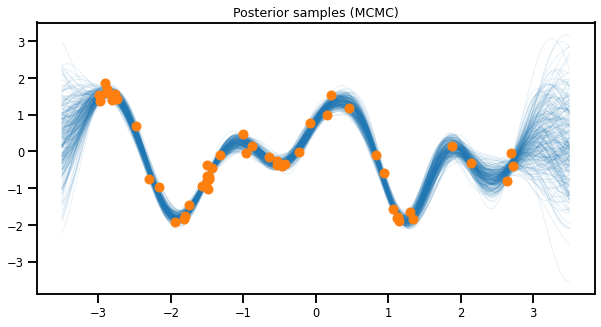

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(xtest, mcmc_posterior_samples[:250].T, color="tab:blue", alpha=0.1, lw=1)
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.set_title("Posterior samples (MCMC)")
plt.show()

## System Information

In [44]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'J. Emmanuel Johnson'

Author: J. Emmanuel Johnson

Last updated: Wed Mar 24 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
jax       : 0.2.10
numpyro   : 0.6.0
matplotlib: 3.3.1
seaborn   : 0.11.1
gpjax     : 0.3.4

Watermark: 2.2.0

